# Predicting severity of heart disease through data analysis

Group 10: Samantha Lam, Sohayl Allibhai, Amanda Yang, Bolun Xie

## Introduction:

Though treatment has advanced, the prevalence of heart disease has risen in lower-income communities, contributing to cardiovascular disease being a leading cause of premature death (Bowry et al. 1151). This trend is reflected in Canada with cardiovascular disease disproportionately increasing in lower-income areas despite the overall decline of heart disease in the general population (Dai et al. 2). There is therefore demand for more efficient methods of diagnosing heart disease and we aim to ascertain the severity of heart disease for unique individuals by analyzing a list of attributes taken from a dataset from the Cleveland Clinic Foundation (Detrano et al. 305). As such, we want to see if we are able to use the variables age, sex, resting blood pressure, chest pain type, and the number of major blood vessels colored by fluoroscopy to classify the severity of a unique individuals heart disease with a (#) accuracy using a K-nearest neighbour classification model. **(why did we choose the classification model and why did we choose these variables)** David W. Aha refined the raw dataset to create the processed dataset that we will utilize. (UCI Machine Learning Repository: Heart Disease Data Set). 

## Methods:
We aim to find the relationship between the chosen five variables and the severity of heart disease to discover which variable has the most influence on heart disease. 

* We picked five variables in total, **age, sex, resting blood pressure *(trestbps)*, chest pain type *(cp)*, and the number of major blood vessels colored by fluoroscopy *(ca)***. We selected **diagnosis of heart disease and severity *(nu)*** as our target variable, which we will compare to each of our five variables.

* We split the data set using chest pain type to straify, and will use the training set to train a classification model that will be used to predict severity of heart disease for a unique individual 

* We plan to utilize a bar plot to show the distribution of sex, as this is a categorical variable that we want to use to make comparisons. Scatter plots will be used to display the relationships between the remainder of our variables due to their quantitative nature.


## Process 

Start by running the cell below to load the libraries needed for data analysis 

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### Preliminary Exploration

Download the dataset and read it into a dataframe.

In [3]:
my_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
download.file(my_url, "cleveland.csv")
cleveland_sel <- read_csv("cleveland.csv", col_names = FALSE)
cleveland_sel <- rename(cleveland_sel, "age" = X1,
                     "sex" = X2,
                     "cp" = X3,
                     "trestbps" = X4,
                     "chol" = X5,
                     "fbs" = X6,
                     "restecg" = X7,
                     "thalach" = X8,
                     "exnag" = X9,
                     "oldpeak" = X10,
                     "slope" = X11,
                     "ca" = X12,
                     "thal" = X13,
                     "num" = X14)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



Here we select for our chosen predictor variables, **age**, **sex**, **cp** (chest pain type), **trestbps** (resting blood pressure), **ca** (number of major blood vessels colored by fluoroscopy) and target variable **nu** (diagnosis of heart disease and severity) that we want to use to build our model


In [4]:
cleveland_df_sel<-select(cleveland_sel,age, sex, cp, trestbps, ca, num)
cleveland_df_sel

age,sex,cp,trestbps,ca,num
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
63,1,1,145,0.0,0
67,1,4,160,3.0,2
67,1,4,120,2.0,1
⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,1.0,3
57,0,2,130,1.0,1
38,1,3,138,?,0


Convert the **num** numerical variable into a factor, as this is what we wish to predict using our model. 

In [5]:
cleveland_df_sel <- cleveland_df_sel %>% mutate(num = as.character(num)) 
cleveland_df_sel <- cleveland_df_sel %>% mutate(num=as_factor(num))
cleveland_df_sel

age,sex,cp,trestbps,ca,num
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
63,1,1,145,0.0,0
67,1,4,160,3.0,2
67,1,4,120,2.0,1
⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,1.0,3
57,0,2,130,1.0,1
38,1,3,138,?,0


Filter out rows with missing data **(do we need to add a reason?)** 

In [6]:
cleveland_df_sel_f <- filter(cleveland_df_sel, ca != "?") 
c_processed <- cleveland_df_sel_f
c_processed

age,sex,cp,trestbps,ca,num
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
63,1,1,145,0.0,0
67,1,4,160,3.0,2
67,1,4,120,2.0,1
⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,2.0,2
57,1,4,130,1.0,3
57,0,2,130,1.0,1


We then explore the data by creating a visual representation of the characters relationships to one another though scatterplots.

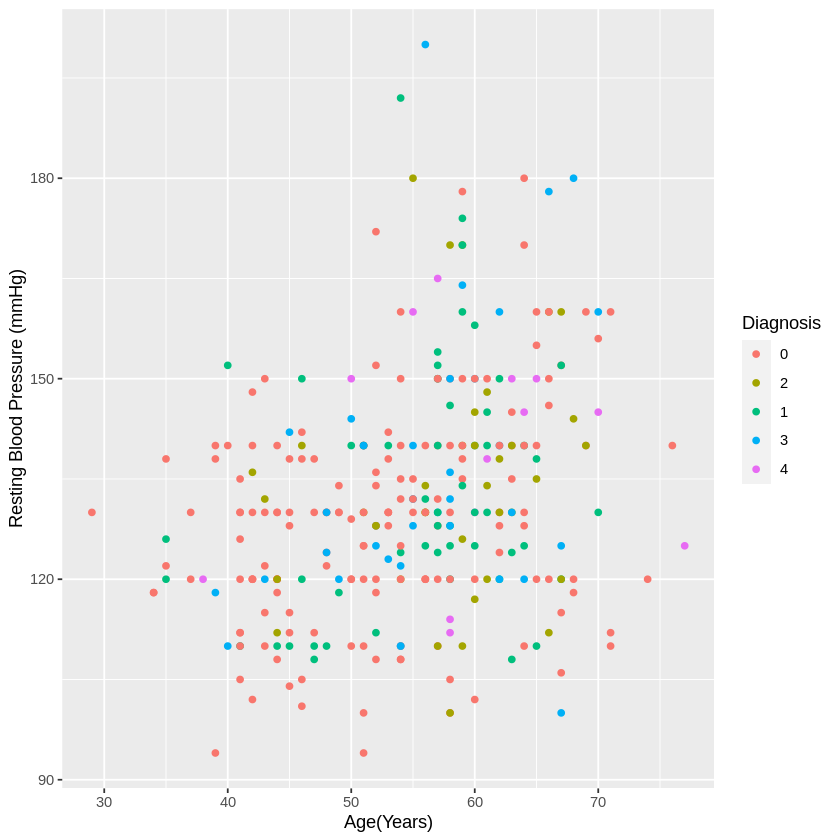

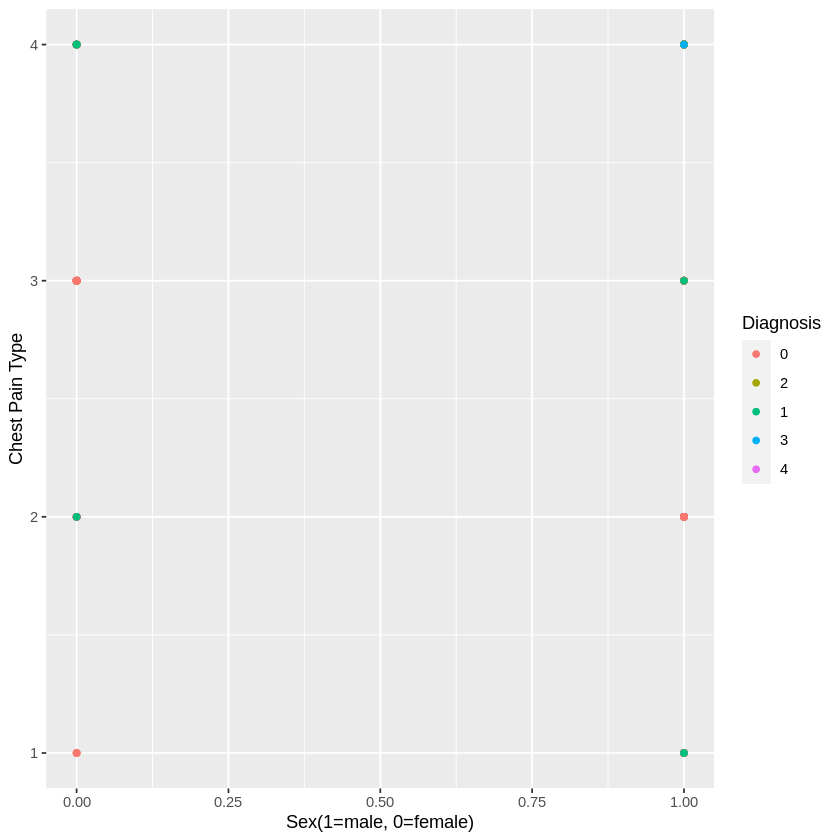

In [7]:
age_trestbps <- c_processed %>% 
    ggplot(aes(x=age,y=trestbps, color = num)) +
    geom_point() + 
    labs(x="Age(Years)", y="Resting Blood Pressure (mmHg)", color = "Diagnosis") 

age_trestbps


sex_cp <- c_processed %>% 
    ggplot(aes(x=sex,y=cp, color = num)) +
    geom_point() + 
    labs(x="Sex(1=male, 0=female)", y="Chest Pain Type", color = "Diagnosis") 

sex_cp


Run this cell to standardise the data

In [8]:
c_processed_scaled <- c_processed %>% 
 mutate(scaled_trestbps= scale(trestbps, center = TRUE))

Run this to set the seed. **(Not optional)** and split the data into traininga and testing sets. **We used a 75/25 split here because ____**

In [22]:
set.seed(888)

patients_split<-initial_split(c_processed, prop = 0.75, strata = num) 
patients_train<- training(patients_split)
patients_test<- testing(patients_split)

patients_test
patients_train



age,sex,cp,trestbps,ca,num
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
62,0,4,140,2.0,3
63,1,4,130,1.0,2
57,1,4,140,0.0,0
⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,110,1.0,2
63,1,4,140,2.0,2
63,0,4,124,0.0,1


age,sex,cp,trestbps,ca,num
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
63,1,1,145,0.0,0
67,1,4,160,3.0,2
67,1,4,120,2.0,1
⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,2.0,2
57,1,4,130,1.0,3
57,0,2,130,1.0,1


`summarise()` ungrouping output (override with `.groups` argument)



num,n
<fct>,<int>
0,161
2,36
1,54
3,35
4,13


Run this cell to obtain the total number of patients in the training set

In [10]:
num_Patients <- patients_train %>% summarize(n_patients = n())
num_Patients

n_patients
<int>
225


Sex has been positively correlated to the severity of heart disease **(EVIDENCE)** making it a key predictor variable. As such, we are interested in finding out the total number of male and female patients respectively in the training set, as well as their ratio. We will achieve this by running the two cells below. 

First obtain the number of male and female patients.

In [11]:
n_each_gender <- patients_train %>% group_by(sex) %>% summarize(n= n())

n_each_gender <- pivot_wider(n_each_gender, names_from = sex, values_from = n)

n_each_gender <- 
        rename(n_each_gender, 
              "female" = "0",
              "male" = "1") %>% mutate("female" = as.character(female), "male" = as.character(male))

n_each_gender <- pivot_longer(n_each_gender, cols = female:male, names_to = "Sex", values_to = "n") %>% mutate(n = as.numeric(n))

n_each_gender 


`summarise()` ungrouping output (override with `.groups` argument)



Sex,n
<chr>,<dbl>
female,76
male,149


To better understand the ratio of male and female patients within the training set, visualise it using a bar graph.

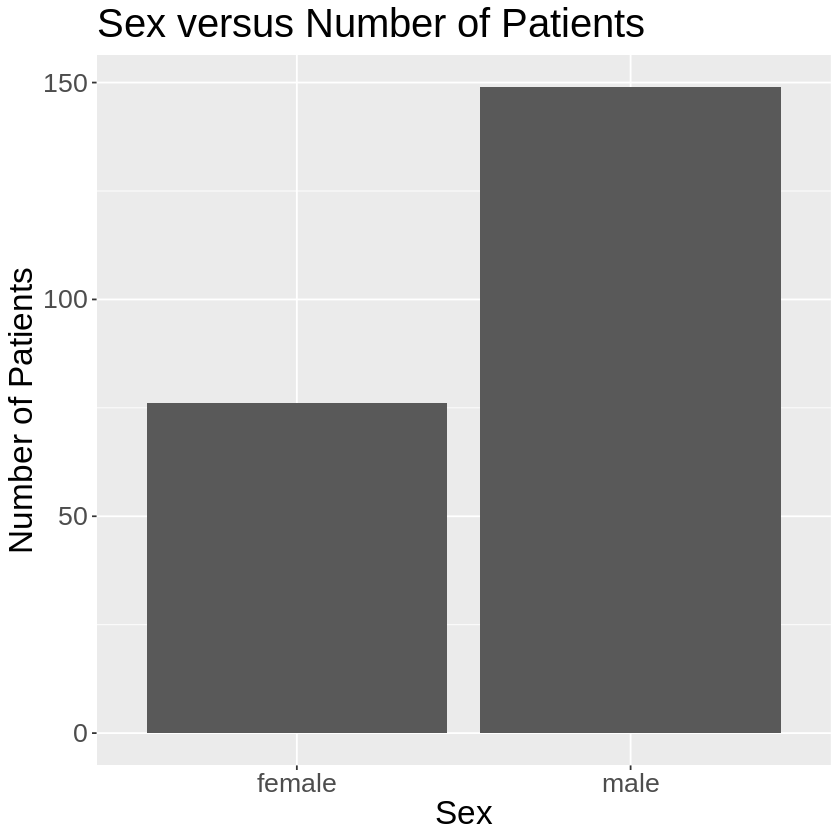

In [12]:

options(repr.plot.width = 7, repr.plot.height = 7)

sex_bar<- ggplot(n_each_gender, aes(x = Sex, y = n)) + 
    geom_bar(stat = "identity") +
    xlab("Sex") +
    ylab("Number of Patients")+
    theme(text = element_text(size = 20))+ 
    ggtitle("Sex versus Number of Patients")

sex_bar

Something abt how age has been shown to be strongly correlated to heart disease, but also the strenght of relationship either impacted/strongly influenced
by sex therefore want to find the relationship between age and sex within our dataset

In [13]:
#Run this cell to find the average age of both female and male patients respectively

mean_age <- patients_train %>% group_by(sex) %>% summarize(avg = mean(age))

mean_age <- pivot_wider(mean_age, names_from = sex, values_from = avg)

mean_age <- 
        rename(mean_age, 
              "female" = "0",
              "male" = "1") %>% mutate("female" = as.character(female), "male" = as.character(male))

mean_age <- pivot_longer(mean_age, cols = female:male, names_to = "sex", values_to = "avg_age") %>% mutate(avg_age = as.numeric(avg_age))

mean_age


`summarise()` ungrouping output (override with `.groups` argument)



sex,avg_age
<chr>,<dbl>
female,55.02632
male,53.21477


As we explore the data, we would also like to find the exact distribution of patients with each type of chest pain (typical angina/atypical angina/non-anginal pain or asymptomatic). We would like to distinguish this bc ______. We acheive this by running the cell below

In [14]:
n_chest_pain <- patients_train %>% group_by(cp) %>% summarize(n = n())

n_chest_pain <- pivot_wider(n_chest_pain, names_from = cp, values_from = n)

n_chest_pain <- 
        rename(n_chest_pain, 
              "typical_angina" = "1",
              "atypical_angina" = "2", "Non_anginal_pain" = "3", "Asymptomatic" = "4") 

n_chest_pain <- pivot_longer(n_chest_pain, cols = typical_angina:Asymptomatic, names_to = "chest_pain", values_to = "n") %>% mutate(n = as.numeric(n))


n_chest_pain


`summarise()` ungrouping output (override with `.groups` argument)



chest_pain,n
<chr>,<dbl>
typical_angina,16
atypical_angina,39
Non_anginal_pain,66
Asymptomatic,104


Explain why resting blood pressure is important and how its relationship/correlation to heart disease is strongly influenced by age. We followed Marateb and Goudarzi's method (216) to straify the age into age groups, as specified below. We explored the distribution of minimum and maximum resting blood pressure in each age group by running the cell below. 

**Age groups:**
* Young adult (18-35 years old)
* Middle adult(36-55 years old)
* Old adult (>55 years old)


In [15]:
#maybe use later in paper, (so don't use in training model) when trying to interpret the data. 

young_adult_bps <- patients_train %>%
select(age,trestbps) %>%
filter(between(age,18, 35))

middle_adult_bps <- patients_train %>%
select(age,trestbps) %>%
filter(between(age,36, 55))

old_adult_bps <- patients_train %>%
select(age, trestbps) %>%
filter(between(age,55,77))

max_young_trestbps <- young_adult_bps %>% 
    arrange(desc(trestbps))%>% 
    head(n=1)

min_young_trestbps <- young_adult_bps %>% 
    arrange(desc(trestbps)) %>%
    tail(n=1)

max_middle_trestbps <- middle_adult_bps %>% 
    arrange(desc(trestbps)) %>%
    head(n=1)

min_middle_trestbps <- middle_adult_bps %>% 
    arrange(desc(trestbps)) %>%
    tail(n=1)

max_old_trestbps <- old_adult_bps %>% 
    arrange(desc(trestbps)) %>%
    head(n=1)

min_old_trestbps <- old_adult_bps %>% 
    arrange(desc(trestbps)) %>%
    tail(n=1)


max_young_trestbps
min_young_trestbps

max_middle_trestbps
min_middle_trestbps

max_old_trestbps
min_old_trestbps


age,trestbps
<dbl>,<dbl>
35,138


age,trestbps
<dbl>,<dbl>
34,118


age,trestbps
<dbl>,<dbl>
54,192


age,trestbps
<dbl>,<dbl>
39,94


age,trestbps
<dbl>,<dbl>
64,180


age,trestbps
<dbl>,<dbl>
58,100


There has been correlations/relationships found between resting blood pressure and ca, and we would like to see if this correlation make these a good predictor pair for diagnosis. 

In [16]:
#Run this cell to obtain mean resting blood pressure in relation to ca

mean_rbp <- patients_train %>% group_by(ca) %>% summarize(avg_rbp = mean(trestbps))
mean_rbp

`summarise()` ungrouping output (override with `.groups` argument)



ca,avg_rbp
<chr>,<dbl>
0.0,129.0709
1.0,129.6383
2.0,134.9500
3.0,138.2353


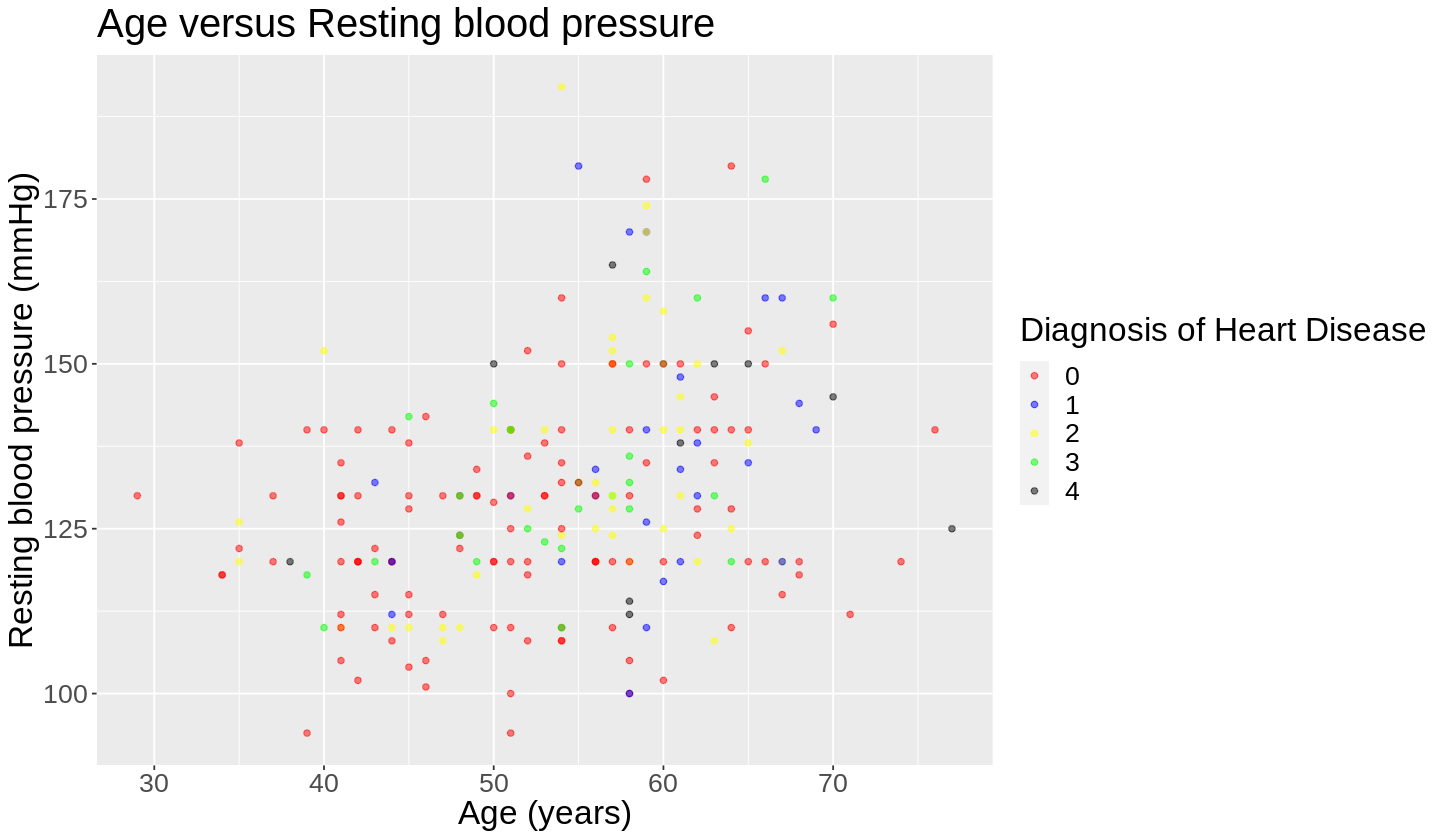

In [17]:
#Run this cell to obtain visualisation of Age versus Resting blood pressure

options(repr.plot.width = 12, repr.plot.height = 7)

age_vs_rbps_plot <- ggplot(patients_train, aes(x = age, y = trestbps, color = as_factor(num))) +
                    geom_point(alpha = 0.5) +
                    labs(x = "Age (years)", y = "Resting blood pressure (mmHg)", color = "Diagnosis of Heart Disease") +
                    theme(text = element_text(size = 20)) + 
                    ggtitle("Age versus Resting blood pressure") +
                    scale_color_manual(labels = c("0", "1","2","3","4"), values = c("red","blue","yellow","green","black"))
age_vs_rbps_plot

### Pre-Process Data

In [18]:
heart_vfold <- vfold_cv(patients_train, v=5, strata = num)

In [19]:
heart_recipe <- recipe(num~. , data = patients_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors)

In [20]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

In [23]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = heart_vfold, grid = k_vals) %>%
    collect_metrics()

accuracies <- knn_results %>% 
              filter(.metric == "accuracy")

accuracies

x Fold1: recipe: Error: All columns selected for the step should be numeric

x Fold2: recipe: Error: All columns selected for the step should be numeric

x Fold3: recipe: Error: All columns selected for the step should be numeric

x Fold4: recipe: Error: All columns selected for the step should be numeric

x Fold5: recipe: Error: All columns selected for the step should be numeric

Warning message:
“All models failed in tune_grid(). See the `.notes` column.”


ERROR: Error: All of the models failed. See the .notes column.


**Plotting accuracy versus K values to observe which K value would be the best to build our model with**

In [ ]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Neighbors", y = "Accuracy Estimate") + 
                  theme(text = element_text(size = 15)) + 
                  ggtitle("Accuracy vs. K")

accuracy_vs_k

In [ ]:
chosen_n <- arrange(accuracies, by = desc(mean)) %>%
            slice(1) %>% 
            pull(mean)

**Building Classification Model**

In [ ]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = chose_n) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit <- workflow() %>%
                add_recipe(heart_recipe) %>%
                add_model(knn_spec) %>%
                fit(data = patients_train)


In [ ]:
patients_test_predictions <- predict(knn_fit, patients_test) %>%
                             bind_cols(patients_test)

patients_test_predictions

In [ ]:
patients_test_predictions <- metrics(truth = num, estimate = .pred_class) %>%
                             filter(.metric == "accuracy")

In [ ]:
confusion <- patients_test_predictions |>
             conf_mat(truth = num, estimate = .pred_class)

confusion

**Predicting new observation**

In [ ]:
new_observation <- tibble(column = x, column = y, ...)
prediction <- predict(knn_fit, new_observation)

prediction

## Expected outcomes and significance
Increasing age and risk of contracting heart disease has consistently shown to be positively correlated (Roth et al. 2985) and the average lifestyle men lead incorporates more high-risk factors for heart disease compared to women. (Dai et al. 6) Older men are therefore more likely to contract cardiovascular diseases, and we would expect to see this reflected in our results.
 
Ultimately, we aim to create a classification model that can contribute to the ongoing effort to help healthcare workers efficiently target individuals at risk of developing heart disease or quickly identify the severity of the disease for patients. 


## Limitations and further questions

The dataset used to train our model used data collected from May 1981 to 1984 (Detrano et al. 305), and the age of the data was assumed negligible. Therefore, it would be interesting to repeat the project with more recent data to compare for any differences in observations. Furthermore, the proportion of low-income individuals in the test group is unknown. Considering the goal of our project, it would be worth exploring if focusing more explicitly on low-income individuals using the same model would produce different results

## Bibliography 

Bowry, Ashna D. K., et al. ‘The Burden of Cardiovascular Disease in Low- and Middle-Income Countries: Epidemiology and Management’. Canadian Journal of Cardiology, vol. 31, no. 9, Sept. 2015, pp. 1151–59. DOI.org (Crossref), https://doi.org/10.1016/j.cjca.2015.06.028.

Dai, Haijiang, et al. ‘Regional and Socioeconomic Disparities in Cardiovascular Disease in Canada during 2005–2016: Evidence from Repeated Nationwide Cross-Sectional Surveys’. BMJ Global Health, vol. 6, no. 11, Nov. 2021, p. e006809. DOI.org (Crossref), https://doi.org/10.1136/bmjgh-2021-006809.

Detrano, Robert, et al. ‘International Application of a New Probability Algorithm for the Diagnosis of Coronary Artery Disease’. The American Journal of Cardiology, vol. 64, no. 5, Aug. 1989, pp. 304–10. ScienceDirect, https://doi.org/10.1016/0002-9149(89)90524-9.

UCI Machine Learning Repository: Heart Disease Data Set. https://archive.ics.uci.edu/ml/datasets/Heart+Disease. Accessed 3 Mar. 2022.

Roth, Gregory A., et al. ‘Global Burden of Cardiovascular Diseases and Risk Factors, 1990–2019’. Journal of the American College of Cardiology, vol. 76, no. 25, Dec. 2020, pp. 2982–3021. DOI.org (Crossref), https://doi.org/10.1016/j.jacc.2020.11.010.

Marateb, Hamid Reza, and Sobhan Goudarzi. ‘A Noninvasive Method for Coronary Artery Diseases Diagnosis Using a Clinically-Interpretable Fuzzy Rule-Based System’. Journal of Research in Medical Sciences : The Official Journal of Isfahan University of Medical Sciences, vol. 20, no. 3, Mar. 2015, pp. 214–23.

